<a href="https://colab.research.google.com/github/10udCryp7/10udCryp7/blob/main/notebooks/VAD_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:08
🔁 Restarting kernel...


In [1]:
!conda -m install textgrid
!conda -m install lightning -c conda-forge

Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - textgrid


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.7.14  |       hbd8a1cb_0         152 KB  conda-forge
    certifi-2025.7.14          |     pyhd8ed1ab_0         156 KB  conda-forge
    conda-24.11.3              |  py311h38be061_0         1.1 MB  conda-forge
    openssl-3.5.1              |       h7b32b05_0         3.0 MB  conda-forge
    textgrid-1.5               |     pyhd8ed1ab_0          12 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.4 MB

The following NEW packages will be INSTALLED:

  textgrid           conda-forge/noarch::textgrid-1.5-pyhd8ed1ab_0 

The following packages will be UPDATED

# Annotation Preparation

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lazyrac00n/speech-activity-detection-datasets")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/speech-activity-detection-datasets


In [3]:
dir = path + '/Data'

In [4]:
import os
import pandas as pd
from textgrid import TextGrid

data = []
list_dir = []
# loop through all files and extract annotation information
for dirname, _, filenames in os.walk(f'{dir}/Annotation'):
    for filename in filenames:
        if not filename.endswith('.TextGrid'):
            continue

        tg_path = os.path.join(dirname, filename)
        tg = TextGrid.fromFile(tg_path)

        # loop through all segment in a file, each is saved as a new row with the same name
        for interval in tg[0]:
            data.append({
                'name': filename.replace('.TextGrid', ''),
                'mark': interval.mark,
                'start': interval.minTime,
                'end': interval.maxTime,
                'tg_path': tg_path,
            })

df = pd.DataFrame(data)

In [5]:
df['audio_path'] = df['tg_path'].str.replace('/Annotation/', '/Audio/', regex=False).str.replace('.TextGrid', '.wav', regex=False)

In [6]:
df

,name,mark,start,end,tg_path,audio_path
0,mic_F02_si791,0,0.00000,2.96300,/kaggle/input/speech-activity-detection-datase...,/kaggle/input/speech-activity-detection-datase...
1,mic_F02_si791,1,2.96300,4.64300,/kaggle/input/speech-activity-detection-datase...,/kaggle/input/speech-activity-detection-datase...
2,mic_F02_si791,0,4.64300,4.84300,/kaggle/input/speech-activity-detection-datase...,/kaggle/input/speech-activity-detection-datase...
3,mic_F02_si791,1,4.84300,5.34700,/kaggle/input/speech-activity-detection-datase...,/kaggle/input/speech-activity-detection-datase...
4,mic_F02_si791,0,5.34700,6.87000,/kaggle/input/speech-activity-detection-datase...,/kaggle/input/speech-activity-detection-datase...
...,...,...,...,...,...,...
5705,sp27_train_sn5,0,1.15375,1.34575,/kaggle/input/speech-activity-detection-datase...,/kaggle/input/speech-activity-detection-datase...
5706,sp27_train_sn5,1,1.34575,1.84175,/kaggle/input/speech-activity-detection-datase...,/kaggle/input/speech-activity-detection-datase...
5707,sp27_train_sn5,0,1.84175,1.96975,/kaggle/input/speech-activity-detection-datase...,/kaggle/input/speech-activity-detection-datase...
5708,sp27_train_sn5,1,1.96975,2.20175,/kaggle/input/speech-activity-detection-datase...,/kaggle/input/speech-activity-detection-datase...


# Dataset Preprocessing

In [7]:
# audio framing: Test code for audio framing
import librosa
import librosa.util

audio_sample_dir = df['audio_path'][0]
audio, sr = librosa.load(audio_sample_dir, sr=16000)

frame_dur = 0.025
frame_length = int(frame_dur * sr)

hop_dur = 0.01
hop_length = int(hop_dur * sr)
frames = librosa.util.frame(audio, frame_length=frame_length, hop_length=hop_length)
frames = frames.T


In [8]:
# duration: see the histogram of duration -> for deciding padding strategy
import librosa
import matplotlib.pyplot as plt
duration_list = []
for audio_path in df['audio_path']:
    audio, sr = librosa.load(audio_path, sr=16000)
    duration = librosa.get_duration(y=audio, sr=sr)
    duration_list.append(duration)
# add duration col
df['duration'] = duration_list

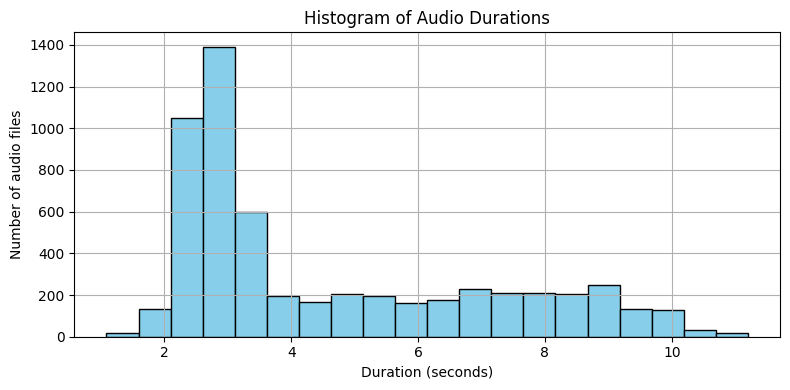

In [9]:
# histogram
plt.figure(figsize=(8, 4))
plt.hist(duration_list, bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of audio files")
plt.grid(True)
plt.tight_layout()
plt.show()

In [164]:
print(df['audio_path'][[0]])

0    /kaggle/input/speech-activity-detection-datase...
Name: audio_path, dtype: object


In [199]:
import kagglehub
import os
import pandas as pd
from textgrid import TextGrid
import librosa
import torch
import numpy as np

def download_data() -> str:
    '''
    Download dataset from kagglehub: speech-activity-detection-datasets

    Returns:
        str: path to dataset files

    Raises:
        Exception: if error occurs
    '''
    try:
      path = kagglehub.dataset_download("lazyrac00n/speech-activity-detection-datasets")
    except Exception as e:
      print(f'Error: {e}')
      return None

    return path

def build_dataframe(data_dir: str) -> pd.DataFrame:
    '''
    Build dataframe from dataset files.
    The strategy is treat each segment of a audio as a new row in the dataframe.
    Use this dataframe by get all row with the same audio name.

    Each row in the dataframe has the following columns:
    - name: name of the audio file
    - mark: label of the segment
    - start: start time of the segment
    - end: end time of the segment
    - tg_path: path to the textgrid file

    Args:
        data_dir (str): path to dataset files

    Returns:
        pd.DataFrame: dataframe with columns: name, mark, start, end, tg_path, audio_path, duration
    '''

    # processing speed may still can be improved
    data = []
    list_dir = []

    # loop through all files for processing
    for dirname, _, filenames in os.walk(f'{data_dir}/Annotation'):
        for filename in filenames:
            # only open TextGrid file
            if not filename.endswith('.TextGrid'):
                continue

            # open TextGrid for processing
            tg_path = os.path.join(dirname, filename)
            tg = TextGrid.fromFile(tg_path)

            # loop through all interval (segment) in a file
            for interval in tg[0]:
                data.append({
                    'name': filename.replace('.TextGrid', ''),
                    'mark': interval.mark,
                    'start': interval.minTime,
                    'end': interval.maxTime,
                    'tg_path': tg_path,
                })

    df = pd.DataFrame(data)
    # create path for easier access
    df['audio_path'] = df['tg_path'].str.replace('/Annotation/', '/Audio/', regex=False).str.replace('.TextGrid', '.wav', regex=False)
    # create duration for analysis (and may be useful later)
    df['duration'] = df['audio_path'].apply(lambda x: librosa.get_duration(filename=x))
    return df

def padding(audio, sr, max_length):
  '''
  padding in the end of each audio so that they have the same length.
  padding before framing.
  maybe can upgrade by using other mode.

  Args:
    audio: waveform, will be converted to np.ndarray so that it can be processed with librosa
    sr: sampling rate, it should be converted to the same in each audio (this is processed in transform())
    max_length: the fix_length for all audio file (in second)
  '''

  if not isinstance(audio, np.ndarray):
    audio = np.array(audio)
  audio = librosa.util.fix_length(audio, size = max_length * sr)
  return audio


def get_frames(audio, sr, frame_dur = 0.025, hop_dur = 0.01) -> torch.Tensor:
  '''
  Audio framing (useful for Voice Activity Detection)
  Args:
    audio: waveform, will be converted to np.ndarray so that it can be processed with librosa
    sr: sampling rate, it should be converted to the same in each audio (this is processed in transform

    frame_dur: frame duration (in second) that used for compute frame_length (used for framing uiwht librosa.util.frame)
    hop_dur: hop duration (in second) that used for compute hop_length (used for framing uiwht librosa.util.frame)

  Returns:
    torch.Tensor: frames with shape (num_frame, frame_size)
  '''
  frame_dur = frame_dur
  frame_length = int(frame_dur * sr)

  hop_dur = hop_dur
  hop_length = int(hop_dur * sr)

  if not isinstance(audio, np.ndarray):
    audio = np.array(audio)

  frames = librosa.util.frame(audio, frame_length=frame_length, hop_length=hop_length)

  # transpose for easier processing (num_frame, frame_size)
  frames = frames.T

  # convert to tensor
  if not isinstance(frames, torch.Tensor):
    frames = torch.from_numpy(frames)

  return frames # (num_frame, frame_size)

def resample(audio, orig_sr, target_sr):
  '''
  resampling so that all audio file have the same sampling rate

  Args:
    audio: waveform, will be converted to np.ndarray so that it can be processed with librosa
    orig_sr: original sampling rate
    target_sr: target sampling rate

  Returns:
    np.ndarray: resampled audio
  '''
  if not isinstance(audio, np.ndarray):
    audio = np.array(audio)

  audio = librosa.resample(y = audio, orig_sr = orig_sr, target_sr = target_sr)
  return audio

def transform(df, audio, orig_sr, target_sr):
  '''
  TODO: add mel-spectrogram option


  transform for training, with three steps:
  1. resampling
  2. padding
  3. framing

  Args:
    audio: waveform, will be converted to np.ndarray so that it can be processed with librosa
    orig_sr: original sampling rate
    target_sr: target sampling rate

  Returns:
    audio: resampled audio with padding and resampling, with shape (waveform, )
    frames: waveform after framing, will be converted to np.ndarray so that it can be processed with librosa, with shape (num_frame, frame_size, 1)
  '''
  # get max length (plus 0.5) for better number rounding

  max_length = round(max(df['duration']) + 0.5)
  # resampling: return np.ndarray
  audio = resample(audio = audio, orig_sr = orig_sr, target_sr = target_sr)

  # sampling rate after changed
  sr = target_sr

  if max_length is None:
    max_length = librosa.get_duration(y=audio, sr=sr)

  # padding: return tensor with padding
  audio = padding(audio, sr, max_length)

  # framing: return tensor of framing
  frames = get_frames(audio, sr)
  # to tensor
  if not isinstance(frames, torch.Tensor):
    frames = torch.from_numpy(frames)


  audio = torch.from_numpy(audio).squeeze(0) # (waveform_len, )
  return audio, frames

def get_label_len(df, path_col):
  sample_path = df[path_col][0]
  audio, sr = torchaudio.load(sample_path)

  transformed_audio, frames = transform(df, audio, sr, 16000)
  return frames.shape[0]

# tạo được kiểu dữ liệu là frames luôn thì tốt

def get_label(frames, frame_dur, hop_dur, sr, label_length, path: str, df: pd.DataFrame, num_additional: int = 2):
  '''
  create label for each waveform (a bunch of frames).
  The step is:
  - create initial label as a zeros tensor with fix length (the fix length will be decided in main class).
  - get all the row with the same path (the path of audio that we want to process)
  - go through all the row (interval or segment), if they are labelled as 1, then change all the frame in this interval as 1.
  + get the floor frame of start and ceil frame of end (each time can be in more than 1 frame)
  + can be label additional frame with num_additional
  - mathematics:
  + let frame_dur = l, hop_dur = p, find i (time point) in which frames?
  + i is in [k * p, k * p + l] as k is the index of frame
  + so k * p <= i <= k * p + l
  + we want to find k, so floor((i-l)/p) <= k <= ceil((i)/p)

  Args:
    frames: waveform, will be converted to np.ndarray so that it can be processed with librosa
    frame_dur: frame duration (in second)
    hop_dur: hop duration (in second)
    sr: sampling rate, it should be converted to the same in each audio (this is processed in transform())
    path: path of audio that will be processed
    df: dataframe for annotation
    num_additional: additional frame

  Returns:
  label: label for each frame of waveform, with shape (num_frame, 1)
  '''

  # create zeros tensor
  label = torch.zeros(label_length)
  # get all row with processed audio path
  df_label = df[df['audio_path'] == path]


  # labelling
  for i in range(len(df_label)):
    mark = df_label.iloc[i]['mark']
    if mark == '1':
      start = df_label.iloc[i]['start']
      end = df_label.iloc[i]['end']

      # mathematics is all you need
      frame_start = round((start - frame_dur)/hop_dur) - num_additional
      frame_end = round(end/hop_dur) + num_additional


      # in case out of range
      if frame_start < 0:
        frame_start = 0

      if frame_end > frames.shape[0]:
        frame_end = frames.shape[0]

      label[frame_start:frame_end] = 1
    else:
      continue

  # for better shape
  label = label.unsqueeze(-1)
  return label


In [200]:
from torch.utils.data import Dataset
import torchaudio
class VADDataset(Dataset):
  '''
  Dataset for Voice Activity Detection.
  * Config file should be integrated for args.

  Args:
    df: dataframe for annotation
    transform: transform for waveform.
    df_path: path of audio that will be processed
    frame_dur: frame duration (in second)
    hop_dur: hop duration (in second)
    target_sr: target sampling rate
    num_additional: additional frame

  Returns:
    processed_waveform: processed waveform with padding and resampling (which are the current features of transform() function), may useful for model likes wav2vec2
    framed_waveform: waveform after framing, will be converted to np.ndarray so that it can be processed with librosa, with shape (num_frame, frame_size, 1)
    label: label for each frame of |waveform, with shape (num_frame, 1)
    label_length: length of label (for model output shape)
  '''
  def __init__(self, df: pd.DataFrame, transform = None):
    self.df = df
    self.transform = transform
    self.df_path = df['audio_path'].drop_duplicates().reset_index(drop=True)
    # save in config
    self.frame_dur = 0.025
    self.hop_dur = 0.01
    self.num_additional = 2
    self.target_sr = 16000

  def __len__(self):
    return len(self.df_path)

  def __getitem__(self, idx):
    row = self.df_path.iloc[idx]
    waveform, sr = torchaudio.load(row)

    if self.transform:
      # transform
      processced_waveform, framed_waveform = self.transform(df = self.df, audio = waveform, orig_sr = sr, target_sr = self.target_sr)

    # get label
    '''
    TODO: label_length should be saved in somewhere for model
    '''
    self.label_length = len(framed_waveform)
    label = get_label(
        framed_waveform,
        label_length=self.label_length,
        frame_dur=self.frame_dur,
        hop_dur=self.hop_dur,
        sr=self.target_sr,
        path=row,
        df=self.df,
        num_additional=self.num_additional)

    return processced_waveform, framed_waveform, label

In [201]:
import lightning as L
from torch.utils.data import random_split, DataLoader

class VADDataModule(L.LightningDataModule):
  def __init__(self, df, transform):
    super().__init__()

    self.df = df
    self.transform = transform
    self.batch_size = 32
    self.label_length = get_label_len(df, 'audio_path')

  def prepare_data(self):
    download_data()
    self.dataset = VADDataset(df = self.df, transform = self.transform)

  def setup(self, stage=None):
    # TODO: add train/val/test splits

    if stage == "fit":
      self.dataset_train = VADDataset(df = self.df, transform = self.transform)
      self.dataset_val = VADDataset(df = self.df, transform = self.transform)

    if stage == "test":
      self.dataset_test = VADDataset(df = self.df, transform = self.transform)

  def train_dataloader(self):
    return DataLoader(self.dataset_train, batch_size=self.batch_size, shuffle=True)

  def val_dataloader(self):
    return DataLoader(self.dataset_val, batch_size=self.batch_size, shuffle=False)

  def test_dataloader(self):
    return DataLoader(self.dataset_test, batch_size=self.batch_size, shuffle=False)

  def predict_dataloader(self):
    return DataLoader(self.dataset_test, batch_size=self.batch_size, shuffle=False)

# Model

In [5]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import lightning as L

class Wav2vec2ASR(nn.Module):
  def __init__(self):
    super().__init__()
    self.wav2vec2 = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H.get_model()

  def forward(self, x):
    return self.wav2vec2(x)

  def get_model(self):
    return self.wav2vec2

class VADMLP(nn.Module):
  def __init__(self, in_shape, out_shape):
    super().__init__()
    self.in_shape = in_shape
    self.out_shape = out_shape

    self.linear = nn.Sequential(
        nn.Linear(in_shape, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, out_shape)
    )

  def forward(self, x):
    return self.linear(x)

class VADModel(L.LightningModule):

  def __init__(self, out_shape, loss = F.binary_cross_entropy, lr = 1e-3):
    super().__init__()

    self.backbone = Wav2vec2ASR()
    for param in self.backbone.parameters():
      param.requires_grad = False

    self.in_shape = self.backbone.get_model().aux.in_features
    self.out_shape = out_shape

    self.mlp = VADMLP(self.in_shape, out_shape)
    self.loss = loss
    self.lr = lr

  def training_step(self, batch, batch_idx):

    processed_waveform, framed_waveform, label = batch
    features, _ = self.backbone.get_model().extract_features(processed_waveform)


    output = self.mlp(features[-1])

    loss = self.loss(output, label)

    return loss

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
    return optimizer


AttributeError: partially initialized module 'torchvision' has no attribute 'extension' (most likely due to a circular import)

In [ ]:
datamodule = VADDataModule(df = df, transform = transform)

model = VADModel(out_shape = datamodule.label_length)

In [ ]:
import lightning as L

trainer = L.Trainer(limit_train_batches=100, max_epochs=1)

trainer.fit(model = model, datamodule = datamodule)



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

  | Name     | Type        | Params | Mode 
-------------------------------------------------
0 | backbone | Wav2vec2ASR | 94.4 M | train
1 | mlp      | VADMLP      | 832 K  | train
-------------------------------------------------
95.2 M    Trainable params
0         Non-trainable params
95.2 M    Total params
380.905   Total estimated model params size (MB)
8         Modules in train mode
201       Modules in eval mode
/usr/local/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:31

Training: |          | 0/? [00:00<?, ?it/s]

In [178]:
model = Wav2vec2ASR()

In [182]:
model

Wav2vec2ASR(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): FeatureExtractor(
      (conv_layers): ModuleList(
        (0): ConvLayerBlock(
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        )
        (1-4): 4 x ConvLayerBlock(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        )
        (5-6): 2 x ConvLayerBlock(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        )
      )
    )
    (encoder): Encoder(
      (feature_projection): FeatureProjection(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (projection): Linear(in_features=512, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (pos_conv_embed): ConvolutionalPositionalEmbedding(
          (conv): ParametrizedConv1d(
            768, 768, kerne